In [4]:
from pyspark.sql import SparkSession, Row
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import col, array, concat, lit, when, count, stddev
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.types import DoubleType, IntegerType, BooleanType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("BasalamAnalysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

# Load dataset
df = spark.read.csv("/kaggle/input/basalam-comments-and-products/BaSalam.products.csv", header=True, inferSchema=True)

# Show original schema and sample data
print("Original Schema:")
df.printSchema()

# Count original rows
original_count = df.count()
print(f"\nOriginal row count: {original_count}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/28 16:22:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Original Schema:
root
 |-- _id: integer (nullable = true)
 |-- _score: double (nullable = true)
 |-- sales_count_week: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- status_id: integer (nullable = true)
 |-- status_title: string (nullable = true)
 |-- stock: integer (nullable = true)
 |-- photo_MEDIUM: string (nullable = true)
 |-- photo_SMALL: string (nullable = true)
 |-- rating_average: double (nullable = true)
 |-- rating_count: integer (nullable = true)
 |-- rating_signals: integer (nullable = true)
 |-- primaryPrice: integer (nullable = true)
 |-- preparationDays: integer (nullable = true)
 |-- weight: integer (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- has_delivery: boolean (nullable = true)
 |-- has_variation: boolean (nullable = true)
 |-- new_categoryId: integer (nullable = true)
 |-- navigation_id: integer (nullable = true)
 |-- vendor_name: string (nullable = true)
 |-- vendor_identifier: string


Original row count: 2411358


### Preprocessing

In [6]:
total_rows = df.count()

# Initialize an empty list to collect final column names
final_cols = []
nan_threshold=0.2
# Loop over the correlated columns
for c in df.columns:
    missing_count = df.select(
        count(when(col(c).isNull(), c)).alias("missing")
    ).collect()[0]["missing"]
    
    missing_percent = missing_count / total_rows
    
    if missing_percent <= nan_threshold:
        final_cols.append(c)
df = df.select(final_cols)
# df.printSchema()
# print(len(df.columns))

# Drop rows with any null values
df_clean = df.dropna()

# Count remaining rows after removing nulls
clean_count = df_clean.count()
print(f"\nRows after removing nulls: {clean_count}")
print(f"Removed {original_count - clean_count} rows ({((original_count - clean_count) / original_count) * 100:.2f}% of data)")

25/04/28 16:31:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.



Rows after removing nulls: 2262039
Removed 149319 rows (6.19% of data)


### Removing Duplicate Columns

In [7]:
all_features = [
    f.name for f in df_clean.schema.fields
    if isinstance(f.dataType, (DoubleType, IntegerType, BooleanType))
]

# Convert Boolean columns to Integer (True/False → 1/0)
for col_name in all_features:
    if isinstance(df_clean.schema[col_name].dataType, BooleanType):
        df_clean = df_clean.withColumn(col_name, col(col_name).cast("integer"))

# Remove constant columns
constant_cols = []
for col_name in all_features:
    std_dev = df_clean.select(stddev(col_name)).collect()[0][0]
    if std_dev == 0 or std_dev is None:
        constant_cols.append(col_name)

all_features = [col for col in all_features if col not in constant_cols]

def plot_correlation_matrix(df, columns):
    correlation_data = df.select(columns).toPandas()
    correlation_matrix = correlation_data.corr()
    
    plt.figure(figsize=(25, 15))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


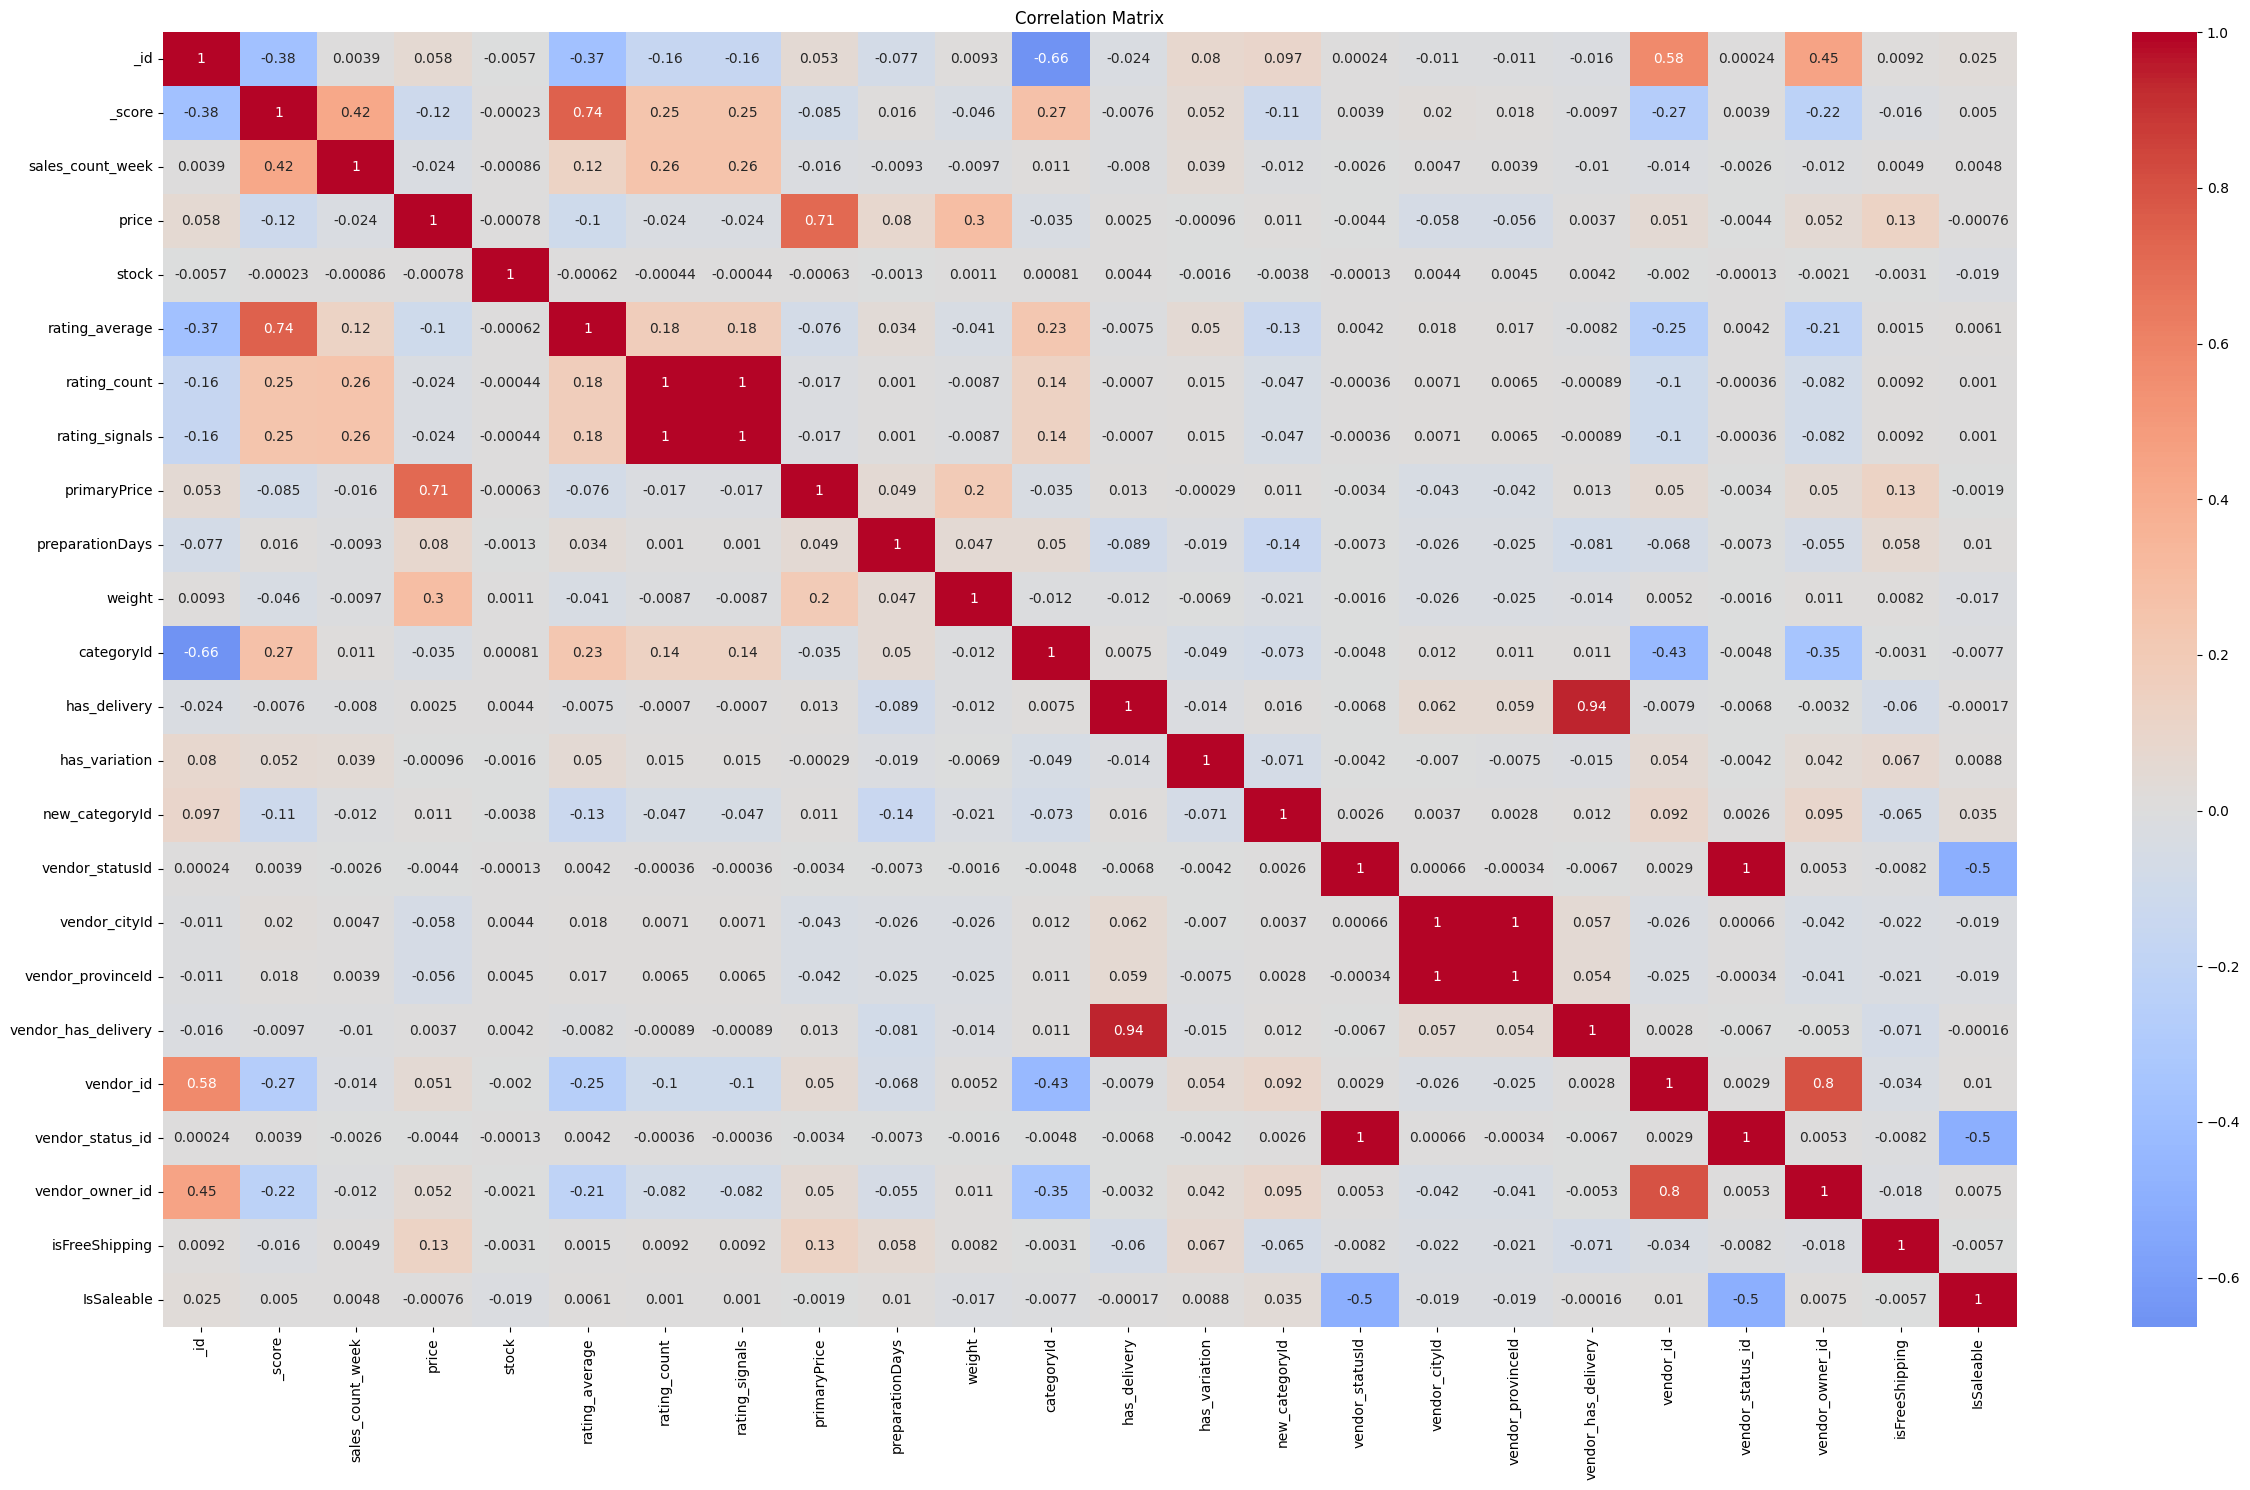

In [5]:
# Plot correlation matrix with all features
plot_correlation_matrix(df, all_features)

In [8]:
df_clean = df_clean.select(all_features)
df_clean = df_clean.drop('rating_signals')
df_clean = df_clean.drop('vendor_provinceId')
df_clean = df_clean.drop('status_id')
df_clean = df_clean.drop('vendor_id')
df_clean = df_clean.drop('_id')
df_clean = df_clean.drop('vendor_owner_id')
df_clean = df_clean.drop('vendor_status_id')
df_clean = df_clean.drop('vendor_cityId')
df_clean = df_clean.drop('vendor_statusId')
df_clean = df_clean.drop('categoryId')
df_clean = df_clean.drop('new_categoryId')

df_clean.printSchema()

root
 |-- _score: double (nullable = true)
 |-- sales_count_week: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- stock: integer (nullable = true)
 |-- rating_average: double (nullable = true)
 |-- rating_count: integer (nullable = true)
 |-- primaryPrice: integer (nullable = true)
 |-- preparationDays: integer (nullable = true)
 |-- weight: integer (nullable = true)
 |-- has_delivery: integer (nullable = true)
 |-- has_variation: integer (nullable = true)
 |-- vendor_has_delivery: integer (nullable = true)
 |-- isFreeShipping: integer (nullable = true)
 |-- IsSaleable: integer (nullable = true)



In [9]:
# Define the score ranges for each class (5 categories)
df_clean = df_clean.withColumn("score_category", 
                               when(df_clean["_score"] < 150, "Low")
                               .when((df_clean["_score"] >= 150) & (df_clean["_score"] < 300), "Medium")
                               .otherwise("High"))

# Calculate min and max values of price
min_price = df_clean.agg({"price": "min"}).collect()[0][0]
max_price = df_clean.agg({"price": "max"}).collect()[0][0]

# Calculate the width of each class (for 5 classes)
class_width = (max_price - min_price) / 5

# Create the price_category column with equal width thresholds for 5 classes
df_clean = df_clean.withColumn("price_category", 
                               when(df_clean["price"] < min_price + class_width, "Very Low")
                               .when((df_clean["price"] >= min_price + class_width) & (df_clean["price"] < min_price + 2 * class_width), "Low")
                               .when((df_clean["price"] >= min_price + 2 * class_width) & (df_clean["price"] < min_price + 3 * class_width), "Medium")
                               .when((df_clean["price"] >= min_price + 3 * class_width) & (df_clean["price"] < min_price + 4 * class_width), "High")
                               .otherwise("Very High"))

# Stock categories
min_stock = df_clean.agg({"stock": "min"}).collect()[0][0]
max_stock = df_clean.agg({"stock": "max"}).collect()[0][0]
class_width = (max_stock - min_stock) / 5
df_clean = df_clean.withColumn("stock_category", 
                               when(df_clean["stock"] < min_stock + class_width, "Very Low")
                               .when((df_clean["stock"] >= min_stock + class_width) & (df_clean["stock"] < min_stock + 2 * class_width), "Low")
                               .when((df_clean["stock"] >= min_stock + 2 * class_width) & (df_clean["stock"] < min_stock + 3 * class_width), "Medium")
                               .when((df_clean["stock"] >= min_stock + 3 * class_width) & (df_clean["stock"] < min_stock + 4 * class_width), "High")
                               .otherwise("Very High"))

# Rating count categories
min_rating_count = df_clean.agg({"rating_count": "min"}).collect()[0][0]
max_rating_count = df_clean.agg({"rating_count": "max"}).collect()[0][0]
class_width = (max_rating_count - min_rating_count) / 5
df_clean = df_clean.withColumn("rating_count_category", 
                               when(df_clean["rating_count"] < min_rating_count + class_width, "Very Low")
                               .when((df_clean["rating_count"] >= min_rating_count + class_width) & (df_clean["rating_count"] < min_rating_count + 2 * class_width), "Low")
                               .when((df_clean["rating_count"] >= min_rating_count + 2 * class_width) & (df_clean["rating_count"] < min_rating_count + 3 * class_width), "Medium")
                               .when((df_clean["rating_count"] >= min_rating_count + 3 * class_width) & (df_clean["rating_count"] < min_rating_count + 4 * class_width), "High")
                               .otherwise("Very High"))

# Primary price categories
min_primaryPrice = df_clean.agg({"primaryPrice": "min"}).collect()[0][0]
max_primaryPrice = df_clean.agg({"primaryPrice": "max"}).collect()[0][0]
class_width = (max_primaryPrice - min_primaryPrice) / 5
df_clean = df_clean.withColumn("primaryPrice_category", 
                               when(df_clean["primaryPrice"] < min_primaryPrice + class_width, "Very Low")
                               .when((df_clean["primaryPrice"] >= min_primaryPrice + class_width) & (df_clean["primaryPrice"] < min_primaryPrice + 2 * class_width), "Low")
                               .when((df_clean["primaryPrice"] >= min_primaryPrice + 2 * class_width) & (df_clean["primaryPrice"] < min_primaryPrice + 3 * class_width), "Medium")
                               .when((df_clean["primaryPrice"] >= min_primaryPrice + 3 * class_width) & (df_clean["primaryPrice"] < min_primaryPrice + 4 * class_width), "High")
                               .otherwise("Very High"))

# Sales count week categories
min_sales_count_week = df_clean.agg({"sales_count_week": "min"}).collect()[0][0]
max_sales_count_week = df_clean.agg({"sales_count_week": "max"}).collect()[0][0]
class_width = (max_sales_count_week - min_sales_count_week) / 5
df_clean = df_clean.withColumn("sales_count_week_category", 
                               when(df_clean["sales_count_week"] < min_sales_count_week + class_width, "Very Low")
                               .when((df_clean["sales_count_week"] >= min_sales_count_week + class_width) & (df_clean["sales_count_week"] < min_sales_count_week + 2 * class_width), "Low")
                               .when((df_clean["sales_count_week"] >= min_sales_count_week + 2 * class_width) & (df_clean["sales_count_week"] < min_sales_count_week + 3 * class_width), "Medium")
                               .when((df_clean["sales_count_week"] >= min_sales_count_week + 3 * class_width) & (df_clean["sales_count_week"] < min_sales_count_week + 4 * class_width), "High")
                               .otherwise("Very High"))

# Preparation days categories
min_preparationDays = df_clean.agg({"preparationDays": "min"}).collect()[0][0]
max_preparationDays = df_clean.agg({"preparationDays": "max"}).collect()[0][0]
class_width = (max_preparationDays - min_preparationDays) / 5
df_clean = df_clean.withColumn("preparationDays_category", 
                               when(df_clean["preparationDays"] < min_preparationDays + class_width, "Very Low")
                               .when((df_clean["preparationDays"] >= min_preparationDays + class_width) & (df_clean["preparationDays"] < min_preparationDays + 2 * class_width), "Low")
                               .when((df_clean["preparationDays"] >= min_preparationDays + 2 * class_width) & (df_clean["preparationDays"] < min_preparationDays + 3 * class_width), "Medium")
                               .when((df_clean["preparationDays"] >= min_preparationDays + 3 * class_width) & (df_clean["preparationDays"] < min_preparationDays + 4 * class_width), "High")
                               .otherwise("Very High"))

# Weight categories
min_weight = df_clean.agg({"weight": "min"}).collect()[0][0]
max_weight = df_clean.agg({"weight": "max"}).collect()[0][0]
class_width = (max_weight - min_weight) / 5
df_clean = df_clean.withColumn("weight_category", 
                               when(df_clean["weight"] < min_weight + class_width, "Very Low")
                               .when((df_clean["weight"] >= min_weight + class_width) & (df_clean["weight"] < min_weight + 2 * class_width), "Low")
                               .when((df_clean["weight"] >= min_weight + 2 * class_width) & (df_clean["weight"] < min_weight + 3 * class_width), "Medium")
                               .when((df_clean["weight"] >= min_weight + 3 * class_width) & (df_clean["weight"] < min_weight + 4 * class_width), "High")
                               .otherwise("Very High"))

In [10]:
df_clean = df_clean.drop('_score')
df_clean = df_clean.drop('price')
df_clean = df_clean.drop('sales_count_week')
df_clean = df_clean.drop('stock')
df_clean = df_clean.drop('rating_count')
df_clean = df_clean.drop('primaryPrice')
df_clean = df_clean.drop('preparationDays')
df_clean = df_clean.drop('weight')

df_clean.printSchema()

root
 |-- rating_average: double (nullable = true)
 |-- has_delivery: integer (nullable = true)
 |-- has_variation: integer (nullable = true)
 |-- vendor_has_delivery: integer (nullable = true)
 |-- isFreeShipping: integer (nullable = true)
 |-- IsSaleable: integer (nullable = true)
 |-- score_category: string (nullable = false)
 |-- price_category: string (nullable = false)
 |-- stock_category: string (nullable = false)
 |-- rating_count_category: string (nullable = false)
 |-- primaryPrice_category: string (nullable = false)
 |-- sales_count_week_category: string (nullable = false)
 |-- preparationDays_category: string (nullable = false)
 |-- weight_category: string (nullable = false)



### Convert to itemsets format 


In [11]:
df_string = df_clean
for column in df_clean.columns:
    df_string = df_string.withColumn(column, 
                                   when(col(column).isNotNull(), 
                                        col(column).cast("string"))
                                   .otherwise(lit("null")))

# First show the dataframe as is
print("\nSample of cleaned data with arrays:")
tempdf = df_string.select(array(*df_string.columns).alias("items"))
tempdf.show(5, truncate=False)


Sample of cleaned data with arrays:
+------------------------------------------------------------------------------------------------+
|items                                                                                           |
+------------------------------------------------------------------------------------------------+
|[4.7, 1, 0, 1, 0, 1, High, Very Low, Very Low, Very Low, Very Low, Low, Very Low, Very Low]     |
|[4.9, 1, 0, 1, 0, 1, High, Very Low, Very Low, Low, Very Low, Low, Very Low, Very Low]          |
|[5.0, 1, 0, 1, 0, 1, High, Very Low, Very Low, Very Low, Very Low, Low, Very Low, Very Low]     |
|[5.0, 1, 0, 1, 0, 1, High, Very Low, Very Low, Very Low, Very Low, Very Low, Very Low, Very Low]|
|[4.9, 1, 0, 1, 0, 1, High, Very Low, Very Low, Very Low, Very Low, Very Low, Very Low, Very Low]|
+------------------------------------------------------------------------------------------------+
only showing top 5 rows



### Append feature name at the beginning of each feature value


In [12]:
cols = df_clean.columns
for c in cols:
    df_clean = df_clean.withColumn(c, concat(lit(f"{c}_"), col(c).cast("string")))

print("\nSample of data with column prefixes:")
df_clean.show(2, truncate=False)


Sample of data with column prefixes:
+------------------+--------------+---------------+---------------------+----------------+------------+-------------------+-----------------------+-----------------------+------------------------------+------------------------------+-----------------------------+---------------------------------+------------------------+
|rating_average    |has_delivery  |has_variation  |vendor_has_delivery  |isFreeShipping  |IsSaleable  |score_category     |price_category         |stock_category         |rating_count_category         |primaryPrice_category         |sales_count_week_category    |preparationDays_category         |weight_category         |
+------------------+--------------+---------------+---------------------+----------------+------------+-------------------+-----------------------+-----------------------+------------------------------+------------------------------+-----------------------------+---------------------------------+-------------------

### Create Item Sets


In [13]:
item_df = df_clean.select(array(*df_clean.columns).alias("items"))
print("\nSample of final itemsets:")
item_df.show(2, truncate=False)

### Apply Apriori algorithm using FP-Growth
# You may need to adjust minSupport and minConfidence based on your dataset size
fp_growth = FPGrowth(itemsCol="items", minSupport=0.05, minConfidence=0.5)
model = fp_growth.fit(item_df)

# Get frequent itemsets
frequent_itemsets = model.freqItemsets

# Generate Association Rules
association_rules = model.associationRules

# Print frequent itemsets
print("\nFrequent Itemsets:")
frequent_itemsets.show(10, truncate=False)

# Print association rules
print("\nAssociation Rules:")
association_rules.show(10, truncate=False)

# Print association rules sorted by support
print("\nAssociation Rules sorted by Support:")
association_rules.sort(col("support").desc()).show(20, truncate=False)

# Print association rules sorted by confidence
print("\nAssociation Rules sorted by Confidence:")
association_rules.sort(col("confidence").desc()).show(20, truncate=False)

# Print association rules sorted by lift
print("\nAssociation Rules sorted by Lift:")
association_rules.sort(col("lift").desc()).show(20, truncate=False)


Sample of final itemsets:
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|items                                                                                                                                                                                                                                                                                                                                          |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Frequent Itemsets:


+------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|items                                                                                                                                                       |freq   |
+------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|[rating_average_0.0]                                                                                                                                        |1491496|
|[rating_average_0.0, has_variation_0]                                                                                                                       |1425967|
|[rating_average_0.0, has_variation_0, sales_count_week_category_Very Low]                                                                                   |1425966

25/04/28 16:42:46 WARN Executor: Managed memory leak detected; size = 5256276 bytes, task 0.0 in stage 272.0 (TID 1125)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------+------------------+------------------+-------------------+
|antecedent                                                                                                                                                                                                                                                                               |consequent                      |confidence        |lift              |support            |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+--------------------------------------------------------------------+------------------------------------+------------------+------------------+------------------+
|antecedent                                                          |consequent                          |confidence        |lift              |support           |
+--------------------------------------------------------------------+------------------------------------+------------------+------------------+------------------+
|[stock_category_Very Low]                                           |[rating_count_category_Very Low]    |0.9999593277046414|0.9999999989750774|0.9999341302249872|
|[rating_count_category_Very Low]                                    |[stock_category_Very Low]           |0.9999748004705681|0.9999999989750773|0.9999341302249872|
|[sales_count_week_category_Very Low]                                |[stock_category_Very Low]           |0.9999748000137937|0.9999999985182915|0.9999160049848831|
|[stock_ca

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+----------+------------------+--------------------+
|antecedent                                                                                                                                                                                                                                                       |consequent                          |confidence|lift              |support             |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+--------

+--------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------+------------------+------------------+-------------------+
|antecedent                                                                                                                                                    |consequent             |confidence        |lift              |support            |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------+------------------+------------------+-------------------+
|[isFreeShipping_1, has_delivery_0, has_variation_0]                                                                                                           |[vendor_has_delivery_0]|0.9850907402157982|2.6402071025637732|0.07220520954766917|
|[isFreeShipping_1, has_deli

### Visualization functions

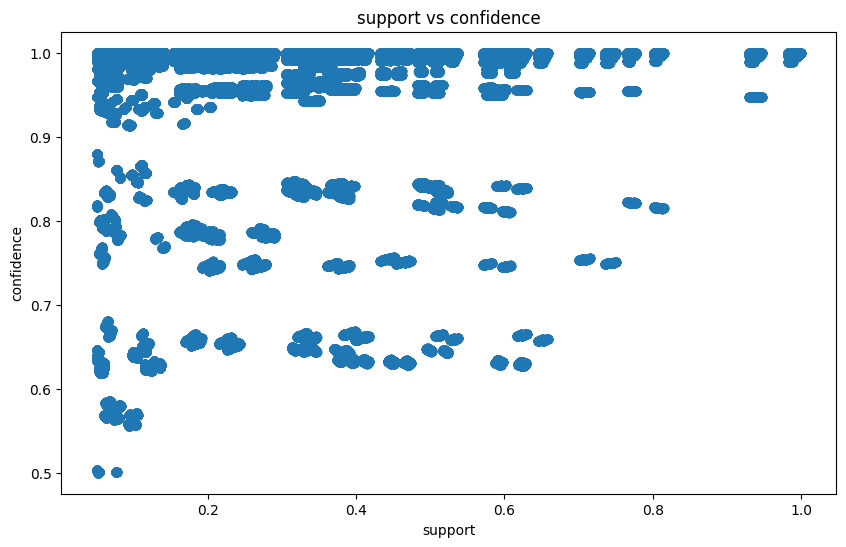

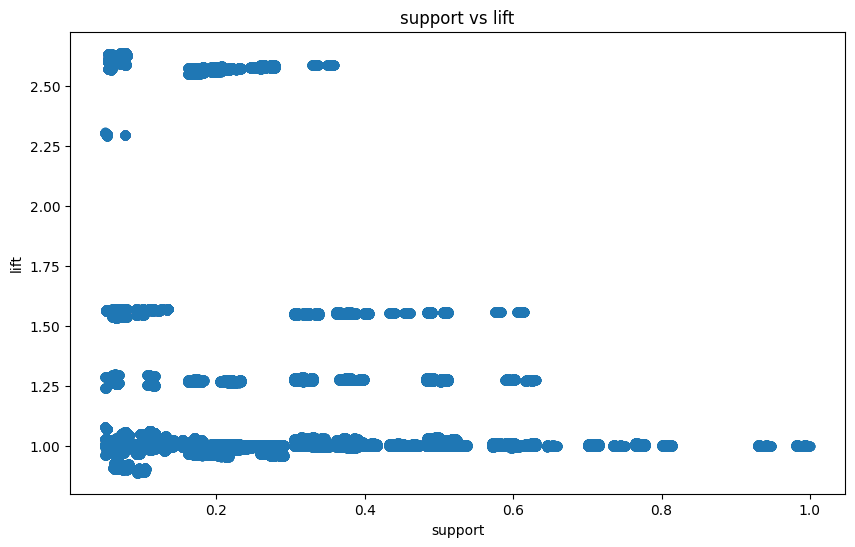

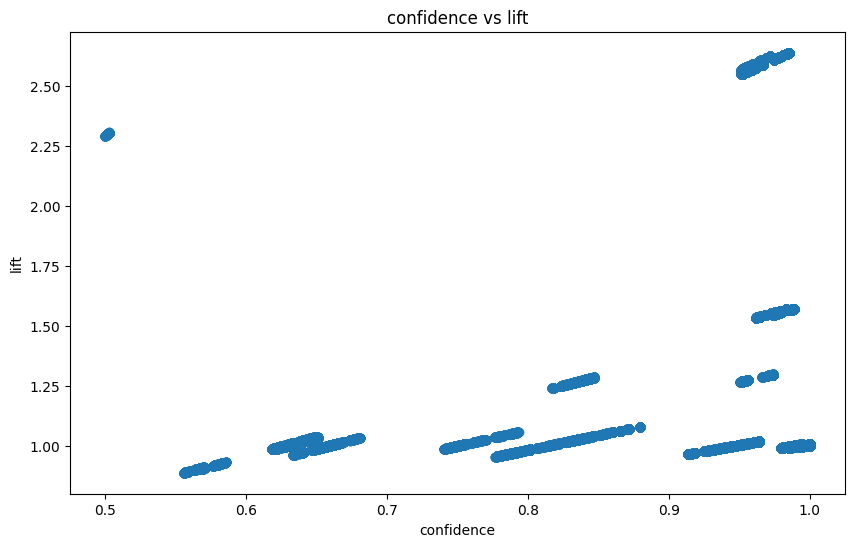

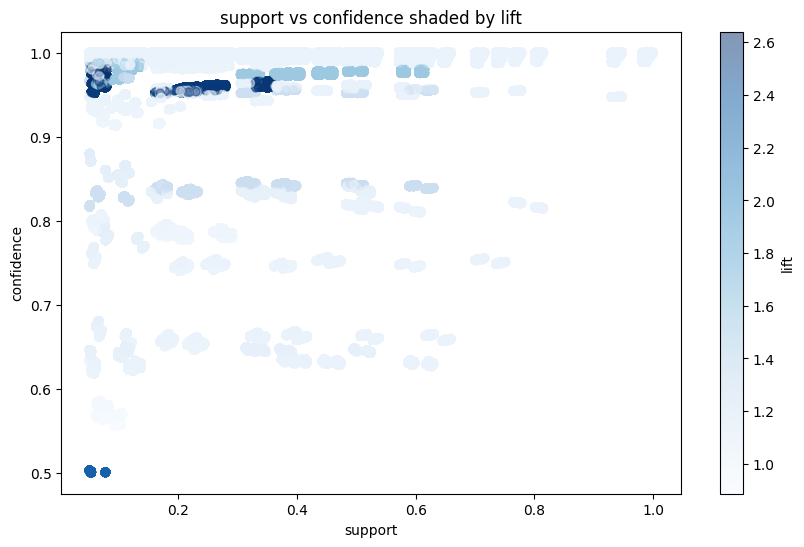


Summary Statistics of Association Rules:
Total number of rules found: 389634
Support range: 0.0501 to 0.9999
Confidence range: 0.5000 to 1.0000
Lift range: 0.8868 to 2.6402

Association rules saved to 'basalam_association_rules.csv'


In [14]:
def plot_feat1_vs_feat2(df, feat1, feat2):
    # Plot support vs. confidence
    plt.figure(figsize=(10, 6))
    plt.scatter(df[feat1], df[feat2], alpha=0.5)
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.title(f"{feat1} vs {feat2}")
    plt.savefig(f'basalam_{feat1}_{feat2}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_feat1_vs_feat2_with_feat3_shade(df, feat1, feat2, feat3):
    # Plot support vs. confidence with shading as lift
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df[feat1], df[feat2], c=df[feat3], cmap='Blues', alpha=0.5)
    plt.colorbar(scatter, label=feat3)
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.title(f'{feat1} vs {feat2} shaded by {feat3}')
    plt.savefig(f'basalam_{feat1}_{feat2}_shade_{feat3}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Convert association rules DataFrame to pandas DataFrame to use matplotlib
association_rules_df = association_rules.toPandas()

# Generate the plots
plot_feat1_vs_feat2(association_rules_df, 'support', 'confidence')
plot_feat1_vs_feat2(association_rules_df, 'support', 'lift')
plot_feat1_vs_feat2(association_rules_df, 'confidence', 'lift')
plot_feat1_vs_feat2_with_feat3_shade(association_rules_df, 'support', 'confidence', 'lift')

# Print summary statistics of the rules
print("\nSummary Statistics of Association Rules:")
print(f"Total number of rules found: {len(association_rules_df)}")
print(f"Support range: {association_rules_df['support'].min():.4f} to {association_rules_df['support'].max():.4f}")
print(f"Confidence range: {association_rules_df['confidence'].min():.4f} to {association_rules_df['confidence'].max():.4f}")
print(f"Lift range: {association_rules_df['lift'].min():.4f} to {association_rules_df['lift'].max():.4f}")

# Optionally, save the rules to a CSV file
association_rules_df.to_csv('basalam_association_rules.csv', index=False)
print("\nAssociation rules saved to 'basalam_association_rules.csv'")